In [97]:
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from pydmd.bopdmd import BOPDMD
from pydmd import DMDc
from scipy.signal import StateSpace, lsim, dlsim, cont2discrete
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
import scipy
from pydmd.plotter import plot_eigs
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft
import dill
from scipy.io import savemat
import pickle

In [2]:
def bopdmd_train_test(svd_rank,num_trials,training_set,training_voltage,test_voltage,time,Btilde,return_training_fit, 
                     conjugate_bool, stable_bool, noise_level):
    optdmd = BOPDMD(svd_rank = svd_rank, compute_A = True) #make our opt and bop objects with the correct
                                                            #number of trials and svd rank
        
        
    if conjugate_bool == True and stable_bool == True:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable', 'conjugate_pairs'})
    elif conjugate_bool == True and stable_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'conjugate_pairs'})
    elif stable_bool == True and conjugate_bool == False:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True, eig_constraints = {'stable'})
    else:
        bopdmd = BOPDMD(svd_rank = svd_rank, num_trials = num_trials, compute_A = True)
    
#     rmse = mean_squared_error(training_set[:, 1], np.zeros(training_set[:, 1].shape), squared=False)
    training_set_func = training_set + np.random.normal(0,  (np.sqrt(np.mean(training_set**2))/ 100.0) * noise_level, training_set.shape)
    bopdmd.fit(training_set_func,time) #fit out data
    
    Atilde = bopdmd.A #get A matrix from bop
    
    
    
    #now we are going to see how well bop does on our test voltages. These will simulate a vacuum shot and
    #be a series of 3 state square waves that are fed into each of the four circuits
    
    tout,yout,xout = lsim((Atilde,Btilde,C,D),test_voltage,time)
    
    return xout,Atilde,bopdmd
    
    if return_training_fit == True:
        tout_train,yout_train,xout_train = lsim((Atilde,Btilde,C,D),train_voltage,time)
        return xout_train
    

In [3]:
# Define the state space model parameters
Amplitude = 600
Amplitude1 = 600
Frequency = 19000  # injector frequency
RunTime = .004
SampleTime = 1e-7 
L1 = 8.0141e-7 # H
L2 = 2.0462e-6 # H
M = .161 * L2  # Coupling coefficient
Mw = .1346 * L2  # Coupling coefficient
Cap = 96e-6  # F
R1 = .0025  # Ohm
R2 = .005  # Ohm
R3 = .005  # Ohm
dT = 1e-7
PhaseAngle1 = 90
PhaseAngle2 = 180
PhaseAngle3 = 270

# Scale factor in front of the entries to the A matrix 
# that are affected by mutual inductance
scalar1 = 1 / ((L2 - Mw) * ( (L2 ** 2) - (4 * M ** 2)  +  2 *L2 * Mw +  (Mw ** 2) ))
x3a =  (-L2 ** 2) * R2 + (2 * M ** 2) * R2 -L2 * Mw * R2
x3b = (-L2 ** 2) + (2 * M ** 2)-L2 * Mw
x3c = (L2 ** 2) * R2 - (2 * M ** 2) * R2 + L2 * Mw * R2 + (L2 ** 2) * R3 - (2 * M ** 2) * R3 + L2 * Mw * R3
x3d = L2 * M * R2 - M * Mw * R2
x3e = L2 * M- M * Mw
x3f = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3g = L2 * M * R2 - M * Mw * R2
x3h = L2 * M- M * Mw
x3i = -L2 * M * R2 + M * Mw * R2 -L2 * M * R3 + M * Mw * R3
x3j = - 2 * (M ** 2) * R2 + L2 * Mw * R2 + (Mw ** 2) * R2
x3k = - 2 * (M ** 2) + L2 * Mw + Mw ** 2
x3l = 2 * (M ** 2) * R2 -L2 * Mw * R2 - (Mw ** 2) * R2 + 2 * R3 * (M ** 2)-L2 * Mw * R3 - R3 * Mw ** 2

# Entries for x6 in A matrix
x6a = -L2 * M * R2 + M * Mw * R2
x6b = -L2 * M + M * Mw
x6c = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3
x6d = R2 * (L2 ** 2)- 2 * R2 * (M ** 2) + L2 * Mw * R2
x6e = (L2 ** 2)- 2 * (M ** 2) + L2 * Mw
x6f = - R2 * (L2 ** 2) + 2 * R2 * (M ** 2)-L2 * Mw * R2 - R3 * (L2 ** 2) + 2 * R3 * (M ** 2)-L2 * Mw * R3
x6g = 2 * R2 * (M ** 2)-L2 * Mw * R2 - R2 * (Mw ** 2)
x6h = 2 * (M ** 2)-L2 * Mw- (Mw ** 2)
x6i = - 2 * R2 * (M ** 2) + L2 * Mw * R2 + R2 * (Mw ** 2)- 2 * R3 * (M ** 2) + L2 * Mw * R3 + R3 * (Mw ** 2)
x6j = -L2 * M * R2 + M * Mw * R2
x6k = -L2 * M + M * Mw
x6l = L2 * M * R2 - M * Mw * R2 + L2 * M * R3 - M * Mw * R3

# Entries for x9 in A matrix
x9a = -L2 * M * R2  +  M * Mw * R2
x9b = -L2 * M  +  M * Mw
x9c = L2 * M * R2 - M * Mw * R2 *  +  L2 * M * R3  - M * Mw * R3
x9d = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2
x9e = 2 * (M ** 2) - L2 * Mw - (Mw ** 2)
x9f = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  +  (Mw ** 2) * R2 - 2 * (M ** 2) * R3  +  L2 * Mw * R3  +  (Mw ** 2) * R3
x9g =(L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2
x9h = (L2 ** 2) - 2 * (M ** 2)  +  L2 * Mw
x9i = - (L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2 - (L2 ** 2) * R3  +  2 * (M ** 2) * R3 - L2 * Mw * R3
x9j = -L2 * M * R2  +  M * Mw * R2
x9k = -L2 * M  +  M * Mw 
x9l = L2 * M * R2 - M * Mw * R2  +  L2 * M * R3 - M * Mw * R3

#Entries for x12 in A matrix
x12a = - 2 * (M ** 2) * R2 +  L2 * Mw * R2  + (Mw ** 2) * R2
x12b = - 2 * (M ** 2)  +  L2 * Mw  +  (Mw ** 2)
x12c = 2 * (M ** 2) * R2 - L2 * Mw * R2 - (Mw ** 2) * R2  +  2 * (M ** 2) * R3 - L2 * Mw * R3 - (Mw ** 2) * R3
x12d = L2 * M * R2 - M * Mw * R2
x12e = L2 * M - M * Mw
x12f = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12g = L2 * M * R2 - M * Mw * R2
x12h = L2 * M - M * Mw
x12i = -L2 * M * R2  +  M * Mw * R2 - L2 * M * R3  +  M * Mw * R3
x12j = (-L2 ** 2) * R2  +  2 * (M ** 2) * R2 - L2 * Mw * R2
x12k = (-L2 ** 2)  +  2 * (M ** 2) - L2 * Mw
x12l = (L2 ** 2) * R2 - 2 * (M ** 2) * R2  +  L2 * Mw * R2  +  (L2 ** 2) * R3 - 2 * (M ** 2) * R3  +  L2 * Mw * R3



In [94]:
A = np.array([[((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [1 / Cap, 0, -1 / Cap, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
     [-scalar1 * x3a, -scalar1 * x3b,-scalar1 * x3c, -scalar1 * x3d, 
      -scalar1 * x3e, -scalar1 * x3f, -scalar1 * x3g, -scalar1 * x3h, 
      -scalar1 * x3i, -scalar1 * x3j, -scalar1 * x3k, -scalar1 * x3l],
     [0, 0, 0, ((-1 / L1)*(R1 + R2)), -1 / L1, R2*1 / L1, 0, 0, 0, 0, 0, 0], 
     [0, 0, 0,  1 / Cap, 0, -1 / Cap, 0, 0, 0, 0, 0, 0], 
     [scalar1 * x6a, scalar1 * x6b, scalar1 * x6c, scalar1 * x6d, 
      scalar1 * x6e, scalar1 * x6f, scalar1 * x6g, scalar1 * x6h, 
      scalar1 * x6i, scalar1 * x6j, scalar1 * x6k, scalar1 * x6l],
     [0, 0, 0, 0, 0, 0, ((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1, 0, 0, 0], 
     [0, 0, 0, 0, 0, 0, 1 / Cap, 0, -1 / Cap, 0, 0, 0], 
     [scalar1 * x9a, scalar1 * x9b, scalar1 * x9c, scalar1 * x9d, 
      scalar1 * x9e, scalar1 * x9f, scalar1 * x9g, scalar1 * x9h, 
      scalar1 * x9i, scalar1 * x9j, scalar1 * x9k, scalar1 * x9l], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, ((-1 / L1) * (R1 + R2)), -1 / L1, R2 / L1], 
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1 / Cap, 0, -1 / Cap], 
     [-scalar1 * x12a, -scalar1 * x12b, -scalar1 * x12c, -scalar1 * x12d,
      -scalar1 * x12e, -scalar1 * x12f, -scalar1 * x12g, -scalar1 * x12h, 
      -scalar1 * x12i, -scalar1 * x12j, -scalar1 * x12k, -scalar1 * x12l]]
)

B = np.array(
    [[1 / L1, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 1 / L1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1 / L1, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1 / L1],
    [0, 0, 0, 0],
    [0, 0, 0, 0]]
)

C = np.array(
    [[0,0,1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]
)

D = np.zeros((C.shape[0], C.shape[0]))

sysc = StateSpace(A, B, C, D) 
print(A.shape, C.shape, B.shape, D.shape)
print(np.linalg.eigvals(A)) 

(12, 12) (4, 12) (12, 4) (4, 4)
[-5374.04778628+128310.86801552j -5374.04778628-128310.86801552j
 -6150.9991369 +138653.66264826j -6150.9991369 -138653.66264826j
 -6044.9626896 +137273.04653728j -6044.9626896 -137273.04653728j
 -6044.96263763+137273.04653074j -6044.96263763-137273.04653074j
 -2052.57854051     +0.j         -2915.80446125     +0.j
 -2915.80452169     +0.j         -2983.64806906     +0.j        ]


In [102]:
?pickle.dump

In [104]:
filename = 'continuous_vacuum_ss_model'
with open(filename,'wb') as file:
    pickle.dump(sysc,file)
    print(f'object successfully saved to {filename}')


object successfully saved to continuous_vacuum_ss_model


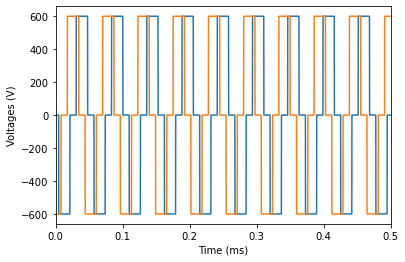

In [5]:
time = np.linspace(0, RunTime, int(RunTime / SampleTime) + 1, endpoint=True)
data = loadmat('voltages.mat')
voltage1 = data['newVoltage']
voltage2 = data['newVoltageShift3']
voltage3 = data['newVoltageShift1']
voltage4 = data['newVoltageShift2']

plt.plot(time * 1e3, voltage1)
plt.plot(time * 1e3, voltage3)
plt.xlim(0, 0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Voltages (V)')
plt.show()

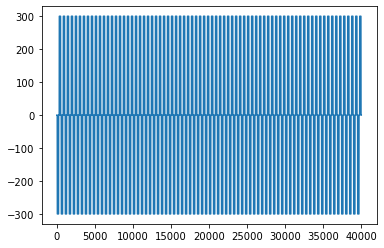

In [6]:
plt.plot(voltage1/2)

7419.141658465024


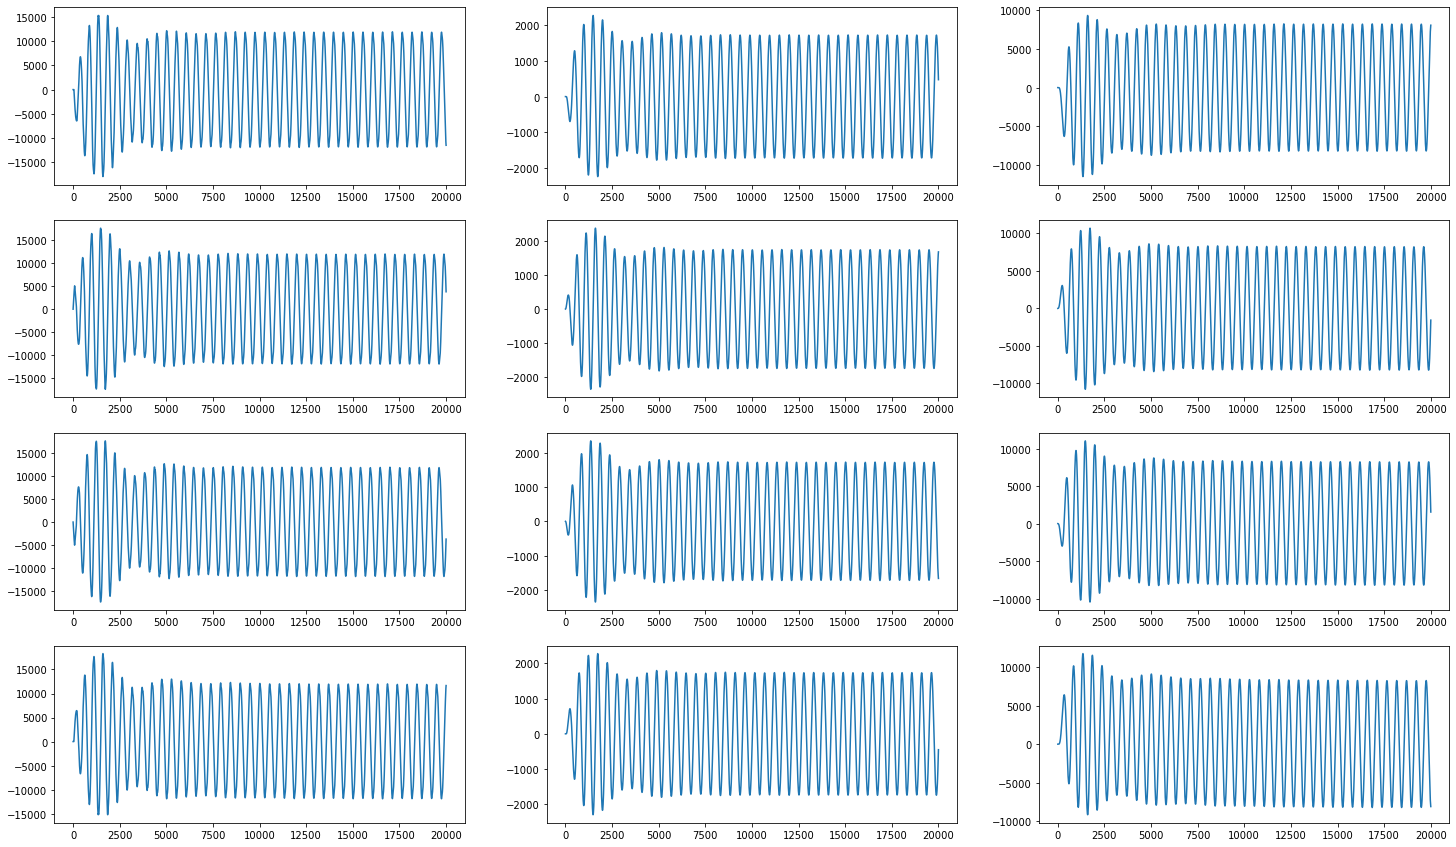

In [7]:
voltages = np.hstack([voltage1, voltage2, voltage3, voltage4])

#Simulating 40001 samples takes too much memory from my poor laptop, so I'm going to cut the shot in half
half_time = time[0:int(len(time)/2)]
half_voltages = voltages[0:int(len(time)/2)]

tout, yout, xout_train = lsim(
    sysc, 
    half_voltages, 
    half_time
)



tout_test, yout, xout_test = lsim(
    sysc, 
    half_voltages/3, #Dropping ampltidue by factor of three to make a rudimentary test set
    half_time
    
)
plt.figure(figsize = (25,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(xout_train[:,i])
    
print(np.linalg.cond(xout_train))


In [50]:
#Start with bop,opt, and exact dmd

#Wen we try dmd with 12 modes we get pretty shit prediction. Looking ath the singular values of the dynamics matrix
#indicates that using a rank 4 approximation does the best job of actually capturing the data.
optdmd = BOPDMD(svd_rank = 4,num_trials = 0,compute_A = True)
bopdmd = BOPDMD(svd_rank = 4,num_trials = 5,compute_A = True, eig_constraints = {'stable', 'conjugate_pairs'})
#dmd = DMD(svd_rank = 12, tlsq_rank = 12,exact = True, opt = True)
#Fit all three of our models

#need to transpose our data, and remember this has 10x less samples than the full simulation data so our algorithm can converge


# print(np.shape(xout_test))


time_train = tout
time_test = tout_test

optdmd.fit(xout_train.T,time_train)
bopdmd.fit(xout_train.T,time_train)

# dmd.fit(xout_train)

#get the statistics for forecasting
reconstruction_mean, reconstruction_variance = bopdmd.forecast(time_train)
forecast_mean, forecast_variance = bopdmd.forecast(time_test)



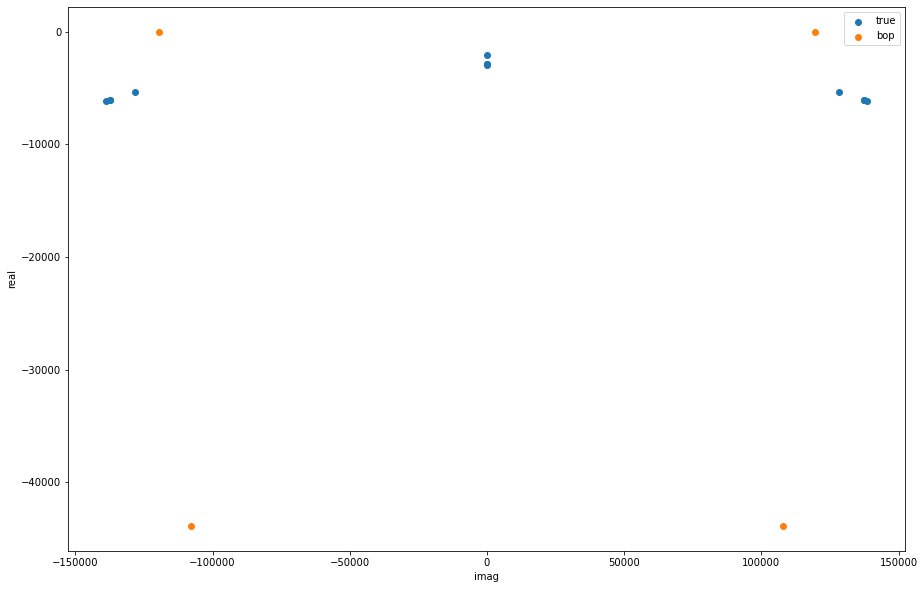

In [51]:
# plt.scatter(np.imag(optdmd.eigs),np.real(optdmd.eigs))

# # plt.scatter(np.imag(bopdmd.eigs),np.real(bopdmd.eigs))

# plt.scatter(np.imag(np.linalg.eigvals(A)),np.real(np.linalg.eigvals(A)))

plt.figure(figsize = (15,10))

plt.scatter(np.imag(np.linalg.eigvals(A)),np.real(np.linalg.eigvals(A)))
plt.scatter(np.imag(bopdmd.eigs),np.real(bopdmd.eigs))
plt.xlabel('imag')
plt.ylabel('real')

plt.legend(['true','bop'])

In [52]:
bopdmd.eigs

array([-3.03659326e+01-119452.44562134j, -4.38681826e+04-107950.53144989j,
       -4.38681826e+04+107950.53144989j, -3.03659326e+01+119452.44562134j])

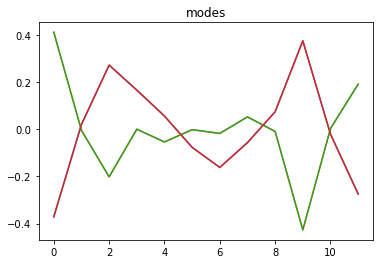

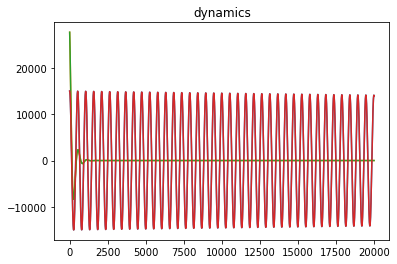

In [53]:
for mode in bopdmd.modes.T:
    plt.plot(mode.real)
    plt.title('modes')
plt.show()

for dynamic in bopdmd.dynamics:
    plt.plot(dynamic.real)
    plt.title('dynamics')
plt.show()

(4, 20000)
(12, 4)


ValueError: x and y must have same first dimension, but have shapes (20000,) and (12,)

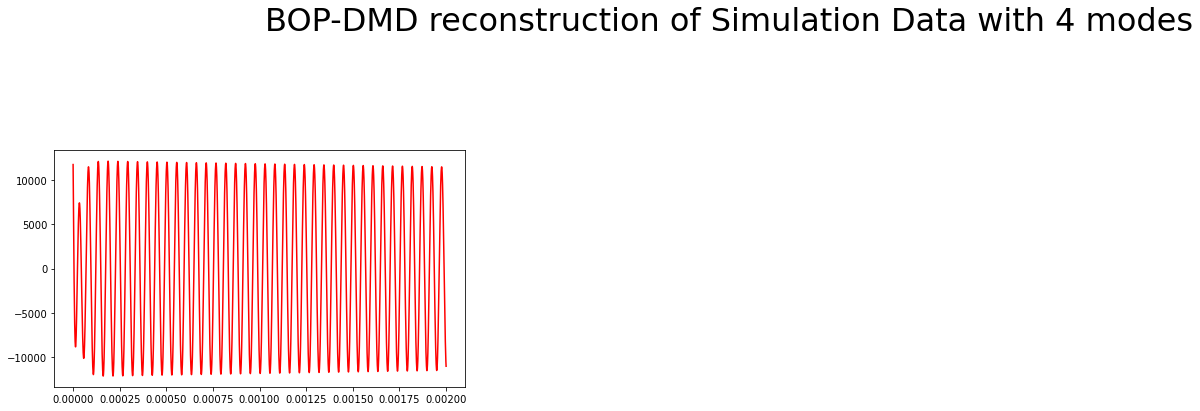

In [54]:
print(np.shape(bopdmd.dynamics.real))
print(np.shape(bopdmd.modes.real))

bopdmd_states = bopdmd.modes@bopdmd.dynamics

count = 0
plt.figure(figsize = (25,20))
plt.suptitle('BOP-DMD reconstruction of Simulation Data with 4 modes',fontsize = 32)
for state,true in zip(bopdmd_states,xout_train):
    plt.subplot(4,3,count+1)
    plt.plot(half_time,state.real,'r')
    plt.plot(half_time,true.T,'k--')
    plt.legend(['bop-dmd','training data'])
    plt.title(f'state {count+1}')
    count = count + 1
    

## Below is a BOP model trained on a full simulate vacuum shot, and as we can see we actually do pretty well. The scale factor error is roughly factor 2-3, depending on which state we are looking at, and we miss the transient in our data. 

[-3.03659326e+01+1.19452446e+05j -4.38681826e+04+1.07950531e+05j
 -4.38681826e+04-1.07950531e+05j -3.03659326e+01-1.19452446e+05j
  4.03749100e-11+3.96891675e-13j  1.45051501e-11+2.07096965e-11j
  8.74068068e-12-1.02323195e-11j  8.53820962e-12+3.50225120e-13j
 -4.50141067e-12+1.51605428e-12j -1.96056523e-12-3.80953223e-12j
  6.35470400e-13-1.35148257e-13j -2.16376849e-12+1.01890242e-14j]


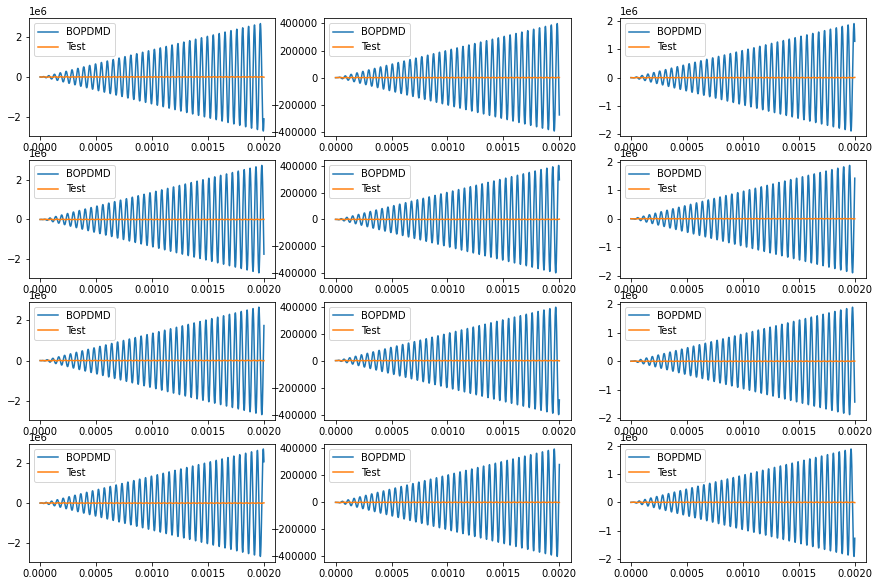

In [55]:
tout,yout,xout = lsim((bopdmd.A, B, C,D), half_voltages, half_time)
print(np.linalg.eigvals(bopdmd.A))

plt.figure(figsize = (15,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout[:,i]))
    plt.plot(half_time,xout_train[:,i])
    plt.legend(['BOPDMD','Test'])

## Below we're going to try BOP DMD on a simulated impulse response

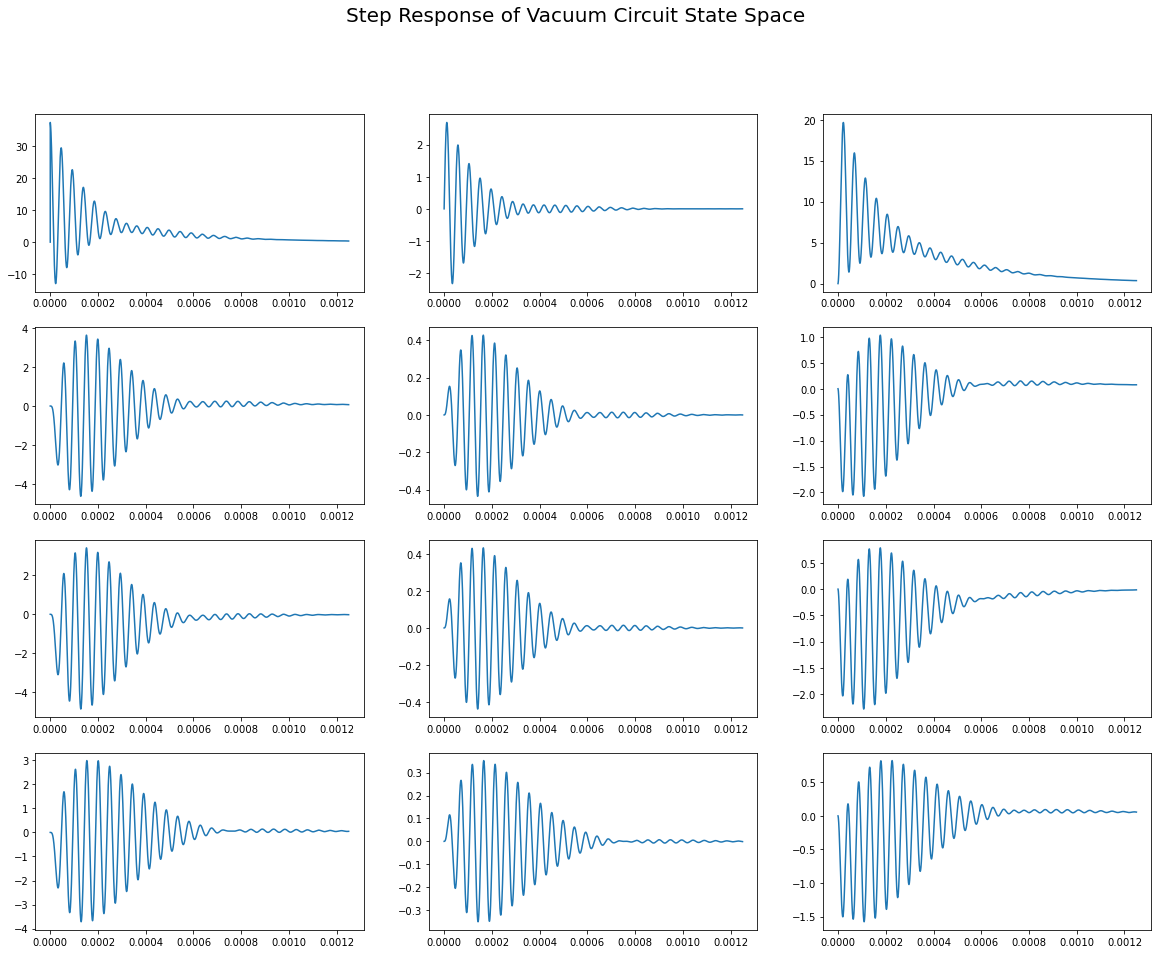

In [8]:
voltage_impulse = np.zeros(np.shape(half_voltages))

voltage_impulse[0,0] = 600

tout,yout,xout_impulse = lsim(sysc,voltage_impulse,half_time)
# Add noise and visualize by chaning the zero in the line below
training_set_func = xout_impulse + np.random.normal(0,  (np.sqrt(np.mean(xout_impulse**2))/ 100.0) * 0, xout_impulse.shape)

plt.figure(figsize = (20,15))
plt.suptitle('Step Response of Vacuum Circuit State Space', fontsize = 20)
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time[0:12500],training_set_func[0:12500,i])

## We're going to make a function that does the training and testing for BOP-DMD, and is going to return all of the results of training from 1 to 20 modes. 

## BOP-DMD is actually able to handle noise really well. Below is an example of the kind of signal we're dealing with. 

## Now let's take the A matrix that comes out of BOPDMD and simulate the step response and compare to the training data

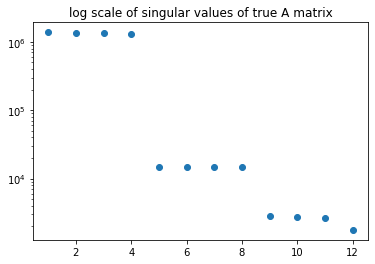

In [10]:
u,s,vt = np.linalg.svd(A, full_matrices = False)


plt.scatter(np.linspace(1,len(s),len(s)),s)

plt.title('log scale of singular values of true A matrix')
plt.yscale('log')

## In this cell below we are training on a single impulse applied to a single power supply

In [11]:
# Atilde_list = []
# xout_bop_list = []
# bop_obj_list = []
# num_samples = 15000
# for i in range(20):

#     [xout_bop_impulse,Atilde, bop_obj] = bopdmd_train_test(svd_rank = i+1, num_trials = 10, 
#                                             training_set = xout_impulse.T[:,0:num_samples],training_voltage = voltage_impulse[0:num_samples,:], test_voltage = half_voltages[0:num_samples,:],
#                                              time = half_time[0:num_samples], Btilde = B, return_training_fit = False, conjugate_bool = True, stable_bool = True,
#                                                  noise_level = 0)
#     Atilde_list.append(Atilde)
#     xout_bop_list.append(xout_bop_impulse)
#     bop_obj_list.append(bop_obj) 
    

In [12]:
# test_error_list = []
# print(np.shape(xout_bop_list[0]))
# for i in xout_bop_list:
#     test_error_list.append( mean_squared_error(xout_test[:,0:num_samples],np.real(i.T)) )
    
# t = np.linspace(1,len(test_error_list),len(test_error_list))
# print(t)
# plt.scatter(t,test_error_list)


# print((test_error_list))

## Using four modes actually seems to work the best. Just looking at the RMSE is a bit misleading

In [13]:
# num =4
# plt.figure(figsize = (20,15))
# for i in range(12):
#     plt.subplot(4,3,i+1)
#     plt.plot(half_time[0:num_samples],np.real(xout_bop_list[num][:,i]))
#     plt.plot(half_time,xout_test[i,:])
#     plt.legend(['bopdmd','test'])

## Modes and Dynamics of the  BOP-DMD model from a single impulse

In [14]:
[vals, vecs] = np.linalg.eig(A)

print(np.shape(vecs))

# for i in vecs.T:
#     plt.plot(i.real)
#     plt.title('modes of A matrix')
# plt.show

(12, 12)


In [15]:


# for mode in bop_obj_list[num].modes.T:
#     plt.plot(mode.real)
#     plt.title('modes')
# plt.show()

# print(np.shape(bop_obj_list[num].modes))

# for dynamic in bop_obj_list[num].dynamics:
#     plt.plot(dynamic.real)
#     plt.title('dynamics')
# plt.show()

# print(np.shape(bop_obj_list[num].modes))


# bop_states = bop_obj_list[num].modes@bop_obj_list[num].dynamics

# plt.figure(figsize = (20,15))

# for i in range(12):
#     plt.subplot(4,3,i+1)
#     plt.plot(np.real(bop_states[i,:]))

In [16]:

# print(np.linalg.eigvals(Atilde_list[num])) #Notice that these four eigevalues are coming in complex conjugate pairs.

# plt.figure(figsize = (15,10))
# plt.scatter(np.imag(np.linalg.eigvals(A)),np.real(np.linalg.eigvals(A)))
# plt.scatter(np.imag(np.linalg.eigvals(Atilde_list[num])),np.real(np.linalg.eigvals(Atilde_list[num])))
# plt.xlabel('imaginary')
# plt.ylabel('real')
# plt.legend(['True A','BOPDMD'])

## Below we complie a list of different configuration of impulses applied to our power supplies. Ultimately it appears that using an impulse on each supply produces the best models

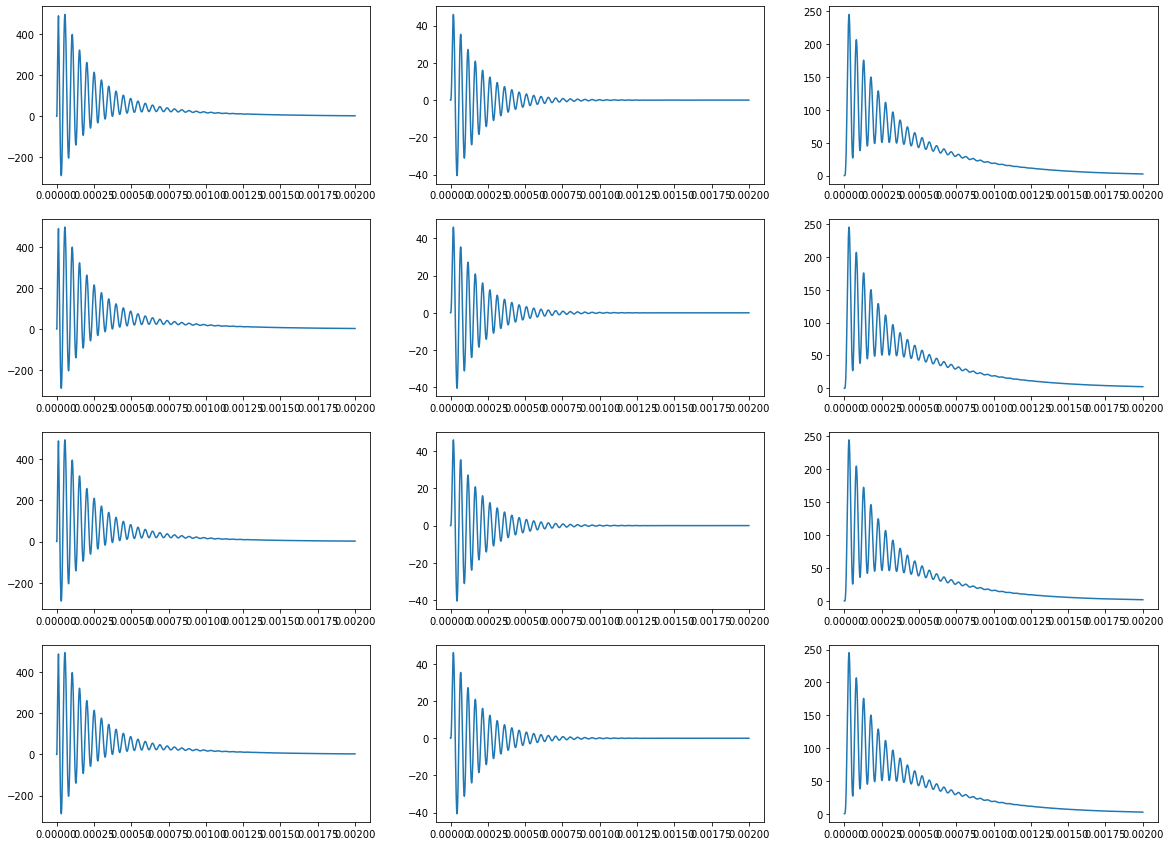

In [17]:
#Apply a voltage impulse to each power supply

num_samples = 15000
voltage_impulse_1 = voltage_impulse
voltage_impulse_2 = np.zeros(np.shape(voltage_impulse))
voltage_impulse_2[0,1] = 600
voltage_impulse_3 = np.zeros(np.shape(voltage_impulse))
voltage_impulse_3[0,2] = 600
voltage_impulse_4 = np.zeros(np.shape(voltage_impulse))
voltage_impulse_4[0,3] = 600

#What if I scale down the impulse drastically
voltage_impulse_5 = np.zeros(np.shape(voltage_impulse))
voltage_impulse_5[20:125,0] = 50
voltage_impulse_5[20:125,1] = 50
voltage_impulse_5[20:125,2] = 50
voltage_impulse_5[20:125,3] = 50

voltage_impulse_6 = np.zeros(np.shape(voltage_impulse))
voltage_impulse_6[0,0] = 600
voltage_impulse_6[0,1] = 600
voltage_impulse_6[0,2] = 600
voltage_impulse_6[0,3] = 600

voltage_impulse_6[int(num_samples/3),0] = 600
voltage_impulse_6[int(num_samples/3),1] = 600
voltage_impulse_6[int(num_samples/3),2] = 600
voltage_impulse_6[int(num_samples/3),3] = 600

voltage_impulse_list = [voltage_impulse_1, voltage_impulse_2,voltage_impulse_3, voltage_impulse_4,voltage_impulse_5,voltage_impulse_6]


#Now we need the four different impulse responses 
impulse_response_list = []
for i in range(len(voltage_impulse_list)):
    tout,yout,xout = lsim((A,B,C,D),voltage_impulse_list[i],half_time)
    impulse_response_list.append(xout)

#Visual check to make sure that the impulse responses are different
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time[:],impulse_response_list[4][:,i])

## Below we are going to fit up to 12 modes on a full simulated vacuum shot and compare the results. 

In [18]:


xout_bop_list = []
Atilde_list = []
bop_obj_list = []
for i in range(8,9):
    [xout,Atilde,bop_obj] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 10,
        training_set = xout_train.T,
        training_voltage = half_voltages,
        test_voltage = half_voltages/3,
        time = half_time,
        Btilde = B,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0)
    xout_bop_list.append(xout)
    Atilde_list.append(Atilde)
    bop_obj_list.append(bop_obj)
        

In [19]:
len(Atilde_list)

1

## It appears that if we fit with 4 modes we get a decent model, but above that it goes to shit. We are about a factor of 10 off, but our reconstruction misses some of the characteristics of the training set

(20000, 12)


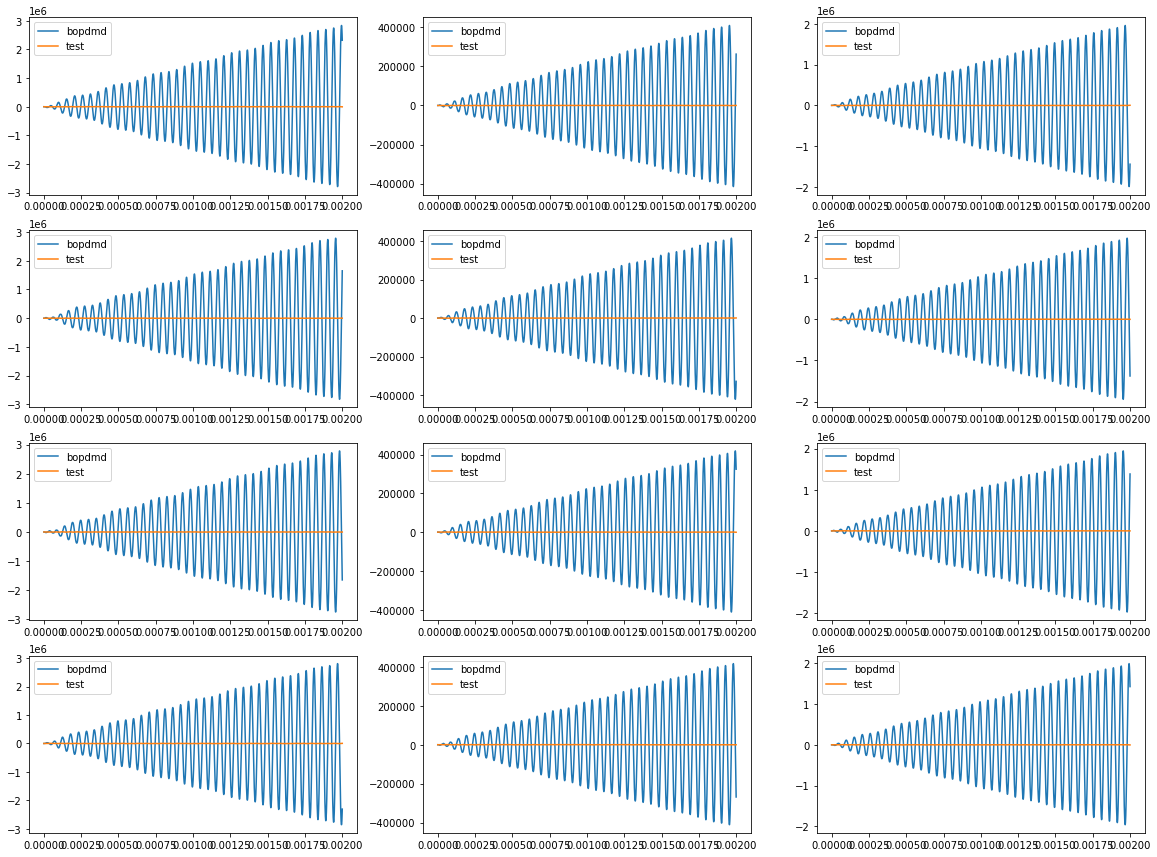

In [20]:
print(np.shape(xout_test))
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time,np.real(xout_bop_list[0][:,i])/10)
    plt.plot(half_time,xout_test[:,i])
    plt.legend(['bopdmd','test'])

## We get some erroneous eigenvalues here, but since BOP is non-convex, we occasionally will do a bit better than this plot below

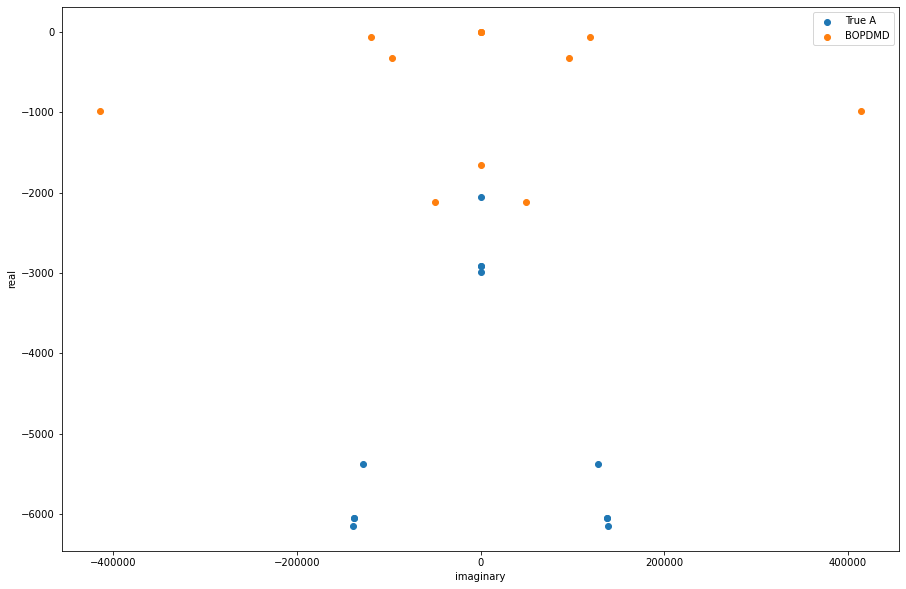

In [21]:
plt.figure(figsize = (15,10))
num = 0
plt.scatter(np.imag(np.linalg.eigvals(A)),np.real(np.linalg.eigvals(A)))
plt.scatter(np.imag(np.linalg.eigvals(Atilde_list[num])),np.real(np.linalg.eigvals(Atilde_list[num])))
plt.xlabel('imaginary')
plt.ylabel('real')
plt.legend(['True A','BOPDMD'])

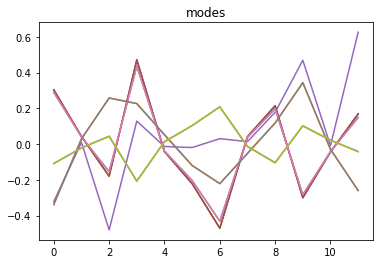

(12, 9)


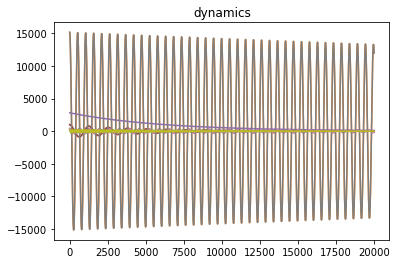

In [22]:

for mode in bop_obj_list[num].modes.T:
    plt.plot(mode.real)
    plt.title('modes')
plt.show()

print(np.shape(bop_obj_list[num].modes))

for dynamic in bop_obj_list[num].dynamics:
    plt.plot(dynamic.real)
    plt.title('dynamics')
plt.show()

## In the cells below we are going to try to train BOP models on simulated impulse response data. We end up getting some interesting errors in these models

In [23]:
xout_impulse_list = []
Atilde_impulse_list = []
bop_impulse_list = []

num_samples = 15000
for i in range(12):

    [xout,Atilde,bop_obj] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 5,
        training_set = impulse_response_list[4].T[:,0:num_samples],
        training_voltage = voltage_impulse_list[4][0:num_samples,:],
        test_voltage = half_voltages[0:num_samples,:],
        time = half_time[0:num_samples],
        Btilde = B,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0)
    xout_impulse_list.append(xout)
    Atilde_impulse_list.append(Atilde)
    bop_impulse_list.append(bop_obj)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 3455207810214542.5. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:270: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[right_half] = 1j * eigenvalues[right_half].imag


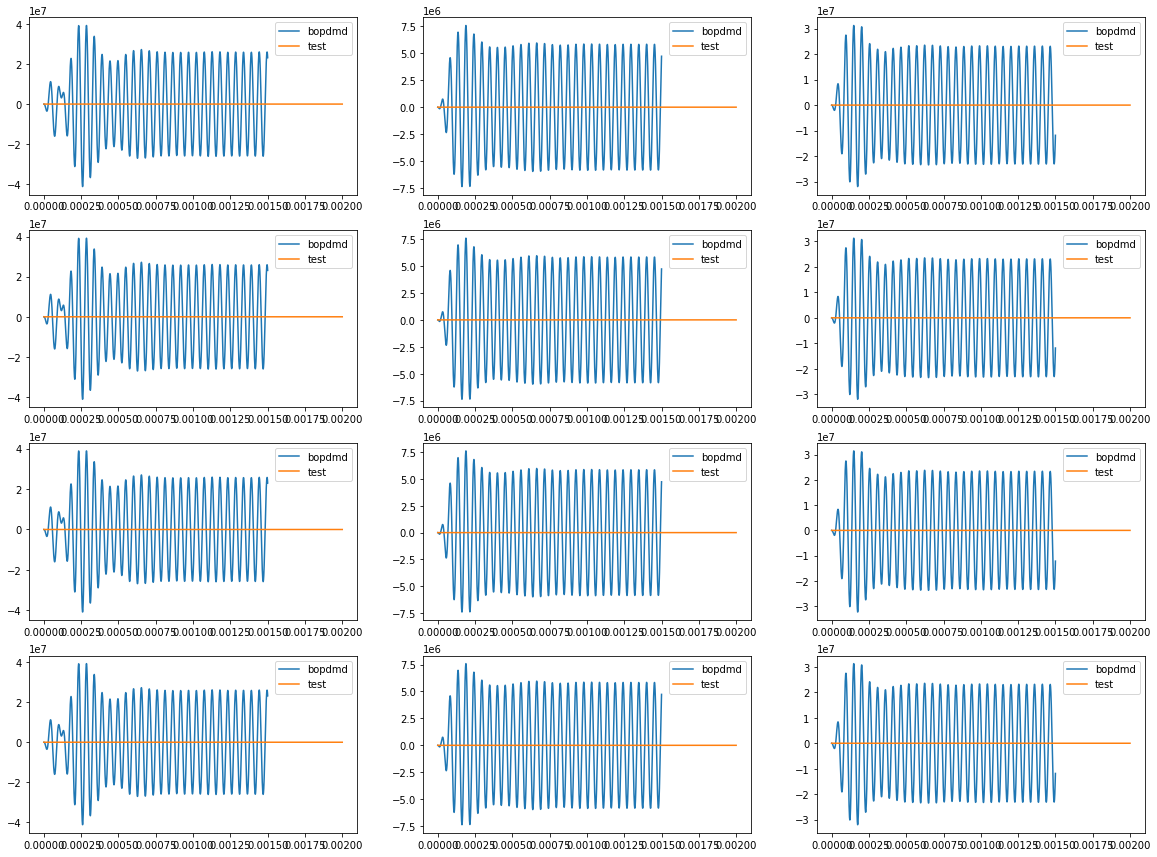

In [24]:
num = 11
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time[0:num_samples],np.real(xout_impulse_list[num][:,i]))
    plt.plot(half_time,xout_test[:,i])
    plt.legend(['bopdmd','test'])

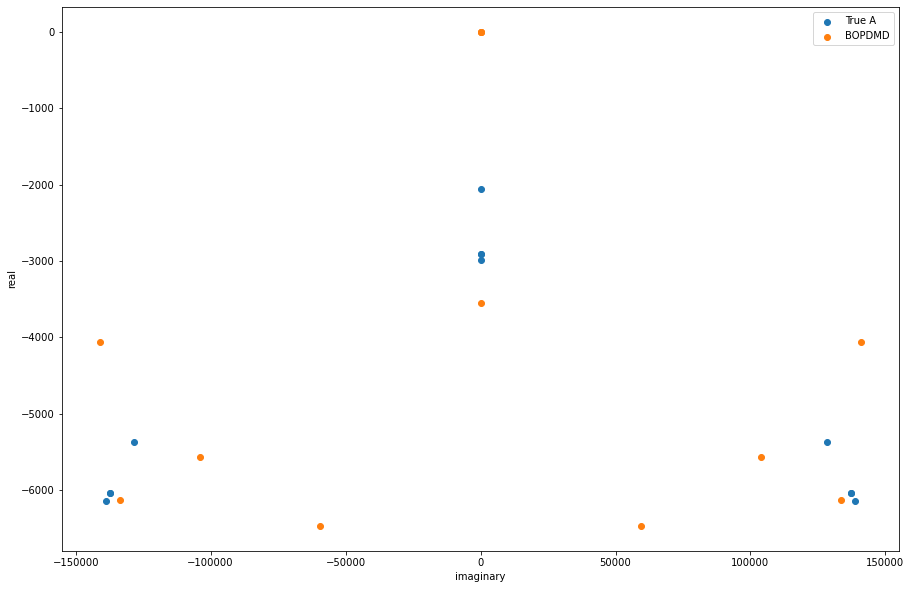

In [25]:
plt.figure(figsize = (15,10))

plt.scatter(np.imag(np.linalg.eigvals(A)),np.real(np.linalg.eigvals(A)))
plt.scatter(np.imag(np.linalg.eigvals(Atilde_impulse_list[num])),np.real(np.linalg.eigvals(Atilde_impulse_list[num])))
plt.xlabel('imaginary')
plt.ylabel('real')
plt.legend(['True A','BOPDMD'])

C:\Users\ducks\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


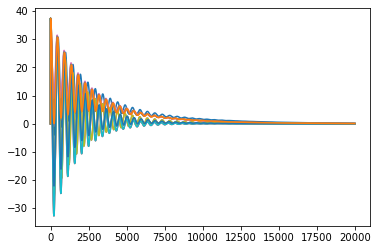

In [26]:
xf = fft(xout_impulse)

plt.plot(xf)

In [27]:
#Plot the differences between the rank truncation and the scaling factor error in the test data

In [28]:
# Boyce and DePrima 

In [29]:
#Try to fit more than 12 modes on this data and see what happens


In [30]:

#There are 167 samples of a non-zero pulse for each 600 volt square wave

In [31]:
optdmd = BOPDMD(svd_rank = 2, compute_A = True)
bopdmd = BOPDMD(svd_rank=5, eig_constraints={"stable", "conjugate_pairs"}, compute_A = True, num_trials = 5)

## Just cuz why not, I'm going to see how BOP does on an experimental vacuum shot

In [32]:
directory = "data/vacuum_shots_220816/good_shots"

dict_keys(['__header__', '__version__', '__globals__', 'shot', 'data', 'shot_num', 'str_length', 'time', 'i_tor', 'v_spa_1', 'v_spa_2', 'v_spa_3', 'v_spa_4', 'i_fcoil_1', 'i_fcoil_2', 'i_fcoil_3', 'i_fcoil_4', 'v_fcoil_1', 'v_fcoil_2', 'v_fcoil_3', 'v_fcoil_4', 'v_cap_1', 'v_cap_2', 'v_cap_3', 'v_cap_4', 'i_L1_1', 'i_L1_2', 'i_L1_3', 'i_L1_4', 'i_cap_1', 'i_cap_2', 'i_cap_3', 'i_cap_4', 'v_L1_1', 'v_L1_2', 'v_L1_3', 'v_L1_4'])


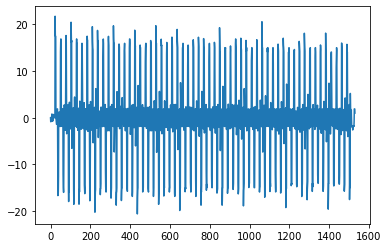

In [33]:
# This cell loads in 4 vacuum shots at the moment and sorts those shots into lists of arrays to be used later for SINDy fits
data_list = []
for i in os.listdir(directory):
    if 'mat' in i:
        data_list.append(loadmat(f"{directory}/{i}"))
    
# data_list.append(loadmat('data/vacuum_shots_220705_220707/220707001'))
input_list = []
state_list = []

print(data_list[0].keys())

experiment_time = data_list[0].get('time')[270:1800]       

i_tor_list = []

for i in data_list:
    i_tor_list.append(i['i_tor'])




data = loadmat('data/shot_220816005_data.mat')
vals = data['shot_220816005']
vals = vals[270:1800,:]

voltage1 = vals[:,1]
voltage2 = vals[:,2]
voltage3 = vals[:,3]
voltage4 = vals[:,4]

trajectory_list = []
inputs_list = []
state_deriv_list = []

state_order = ['i_L1_1','v_cap_1','i_fcoil_1','i_L1_2','v_cap_2','i_fcoil_2','i_L1_3','v_cap_3','i_fcoil_3','i_L1_4','v_cap_4','i_fcoil_4']
state_deriv_order = ['v_L1_1','i_cap_1','v_fcoil_1','v_L1_2','i_cap_2','v_fcoil_2','v_L1_3','i_cap_3','v_fcoil_3','v_L1_4','i_cap_4','v_fcoil_4']
inputs_order = ['v_spa_1','v_spa_2','v_spa_3','v_spa_4']

state_dict = dict.fromkeys(state_order)
state_deriv_dict = dict.fromkeys(state_deriv_order)
inputs_dict = dict.fromkeys(inputs_order)

for d in data_list:
 
    for k,v in d.items():
        if k in state_dict:
            state_dict[k] = v
        if k in state_deriv_dict:
            state_deriv_dict[k] = v
        if k in inputs_dict:
            inputs_dict[k] = v
   
        
    trajectory_list.append(np.asarray(list(state_dict.values())).T)
    inputs_list.append(np.asarray(list((inputs_dict.values()))).T)
    state_deriv_list.append((np.asarray(list(state_deriv_dict.values())).T))




for i in range(len(trajectory_list)):
    trajectory_list[i] = trajectory_list[i][0,270:1800,:]
    inputs_list[i] = inputs_list[i][0,270:1800,:]
    state_deriv_list[i] = state_deriv_list[i][0,270:1800,:]
time = time[270:1800]

plt.plot(inputs_list[0][:,0])

(1530, 12)


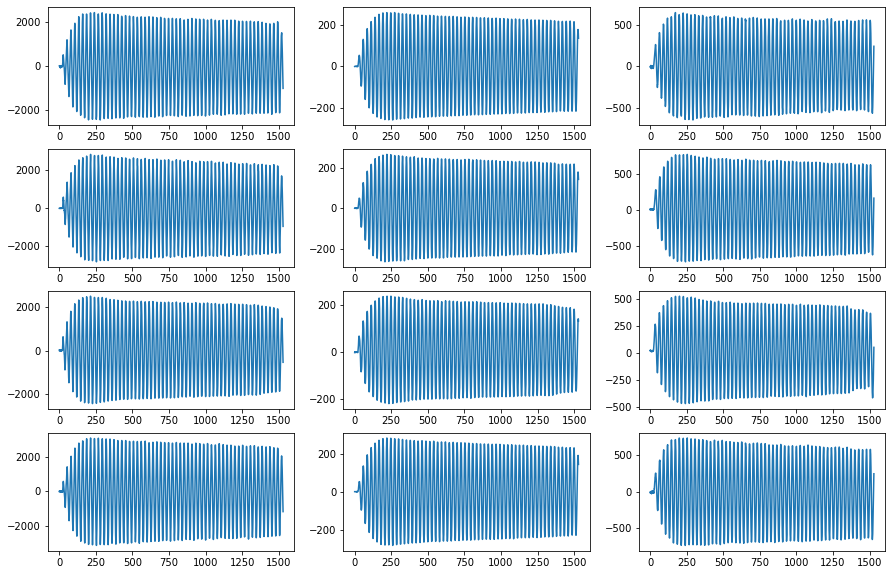

In [35]:
print(np.shape(trajectory_list[2]))

#I've already snipped the data so our time series has less bit noise

plt.figure(figsize = (15,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(trajectory_list[2][:,i])

In [36]:
experiment_time = experiment_time.reshape(len(experiment_time))

print(np.shape(experiment_time))

(1530,)


In [37]:
# The trajectory list object has 3 vacuum shots, and the data becomes friendlier to work with as we go deeper into the list.
xout_experiment_list = []
Atilde_experiment_list = []
bop_obj_experiment_list = []
for i in range(12):

    [xout,Atilde,bop_obj] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 50,
        training_set = trajectory_list[2].T,
        training_voltage = inputs_list[2],
        test_voltage = inputs_list[1],
        time = experiment_time,
        Btilde = B,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0)
    bop_obj_experiment_list.append(bop_obj)
    xout_experiment_list.append(xout)
    Atilde_experiment_list.append(Atilde)


C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:270: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[right_half] = 1j * eigenvalues[right_half].imag
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:534: RuntimeWarning: invalid value encountered in true_divide
  improvement_ratio = actual_improvement / pred_improvement
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:534: RuntimeWarning: divide by zero encountered in true_divide
  improvement_ratio = actual_improvement / pred_improvement


In [38]:
len(bop_obj_experiment_list)

12

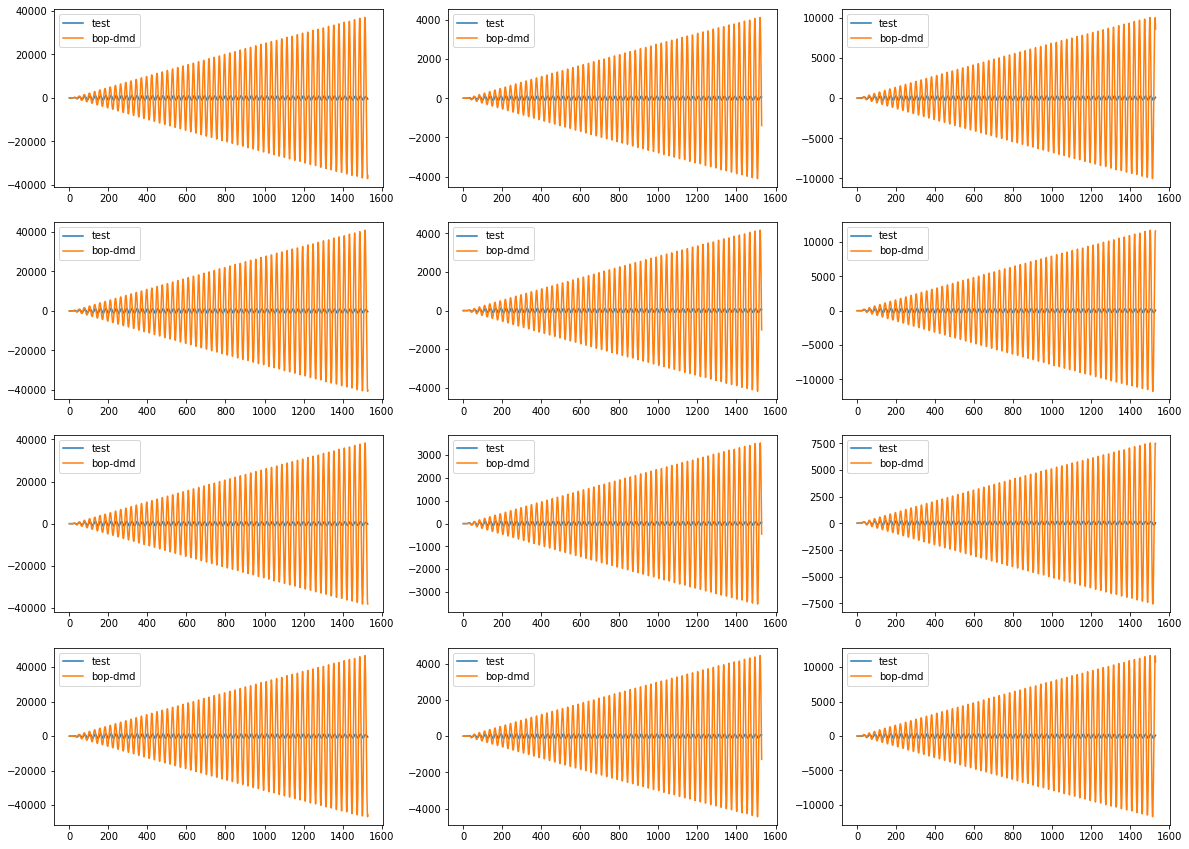

In [39]:
plt.figure(figsize = (20,15))
num = 1
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(trajectory_list[1][:,i])
    plt.plot(np.real(xout_experiment_list[num][:,i]))
    
    plt.legend(['test','bop-dmd'])

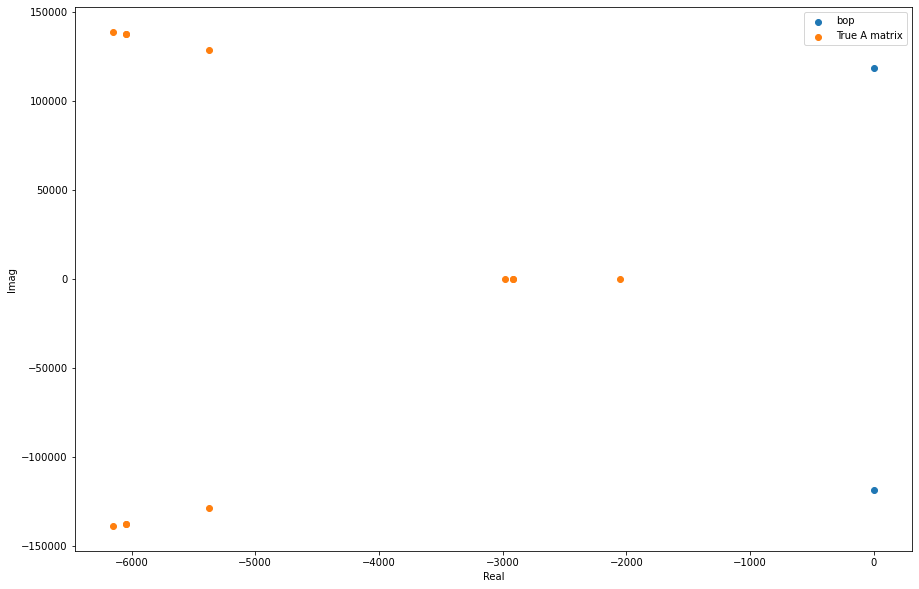

In [40]:
plt.figure(figsize = (15,10))
plt.xlabel('Real')
plt.ylabel('Imag')
plt.scatter(np.real(bop_obj_experiment_list[num].eigs),np.imag(bop_obj_experiment_list[num].eigs))
plt.scatter(np.real(np.linalg.eigvals(A)),np.imag(np.linalg.eigvals(A)))
plt.legend(['bop','True A matrix'])

## This is pretty wild. If I take one of the shitty looking BOP-DMD models, and then I apply the voltage waveform from an experimental shot, I actually get something that looks pretty good. 

In [41]:
print(np.shape(experiment_time))

(1530,)


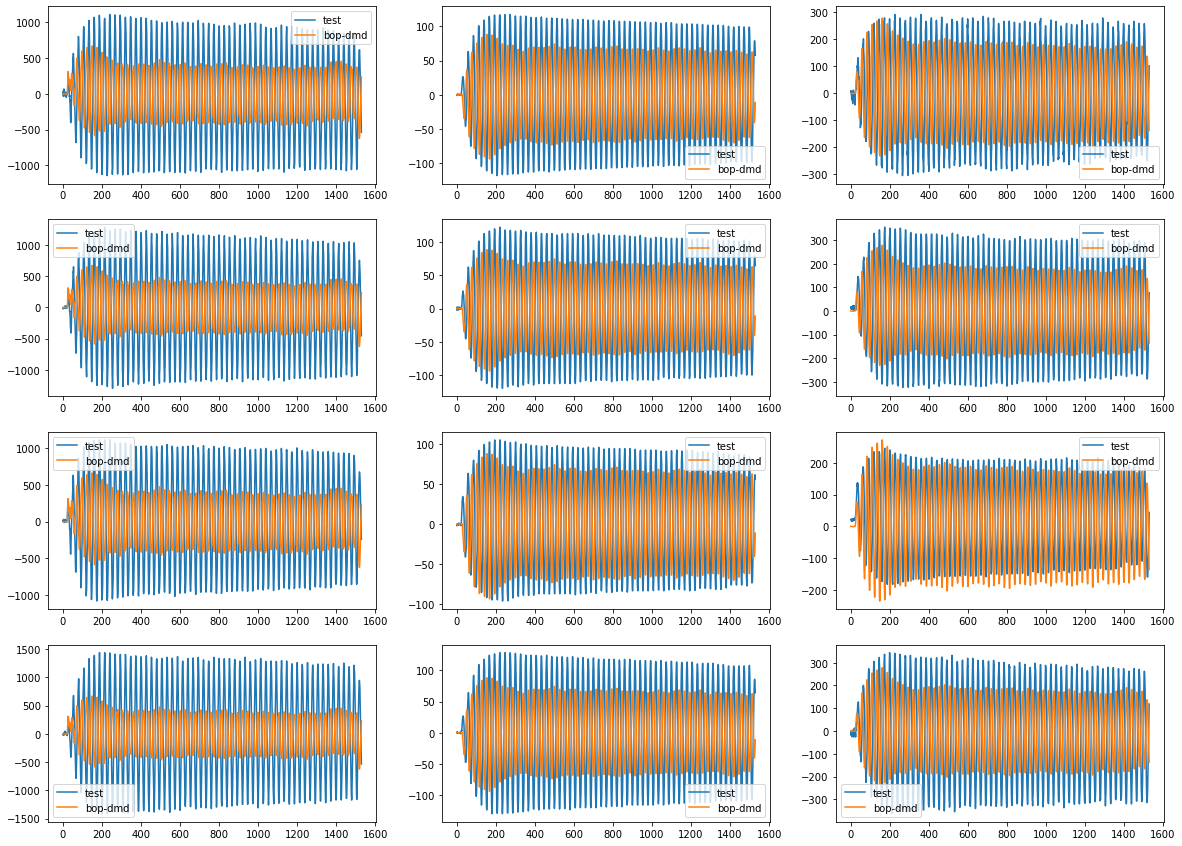

In [46]:
tout,yout,xout = lsim((Atilde_impulse_list[4],B,C,D),inputs_list[1],experiment_time)


plt.figure(figsize = (20,15))
num = 3
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(trajectory_list[1][:,i])
    plt.plot(np.real(xout[:,i]))
    
    plt.legend(['test','bop-dmd'])

## Can we get an even better model? What if we train a BOP-DMD model on something closer to a 'step' response, where we take the peak of one of the square waves, and apply that to our ground truth model. 

(20000, 4)


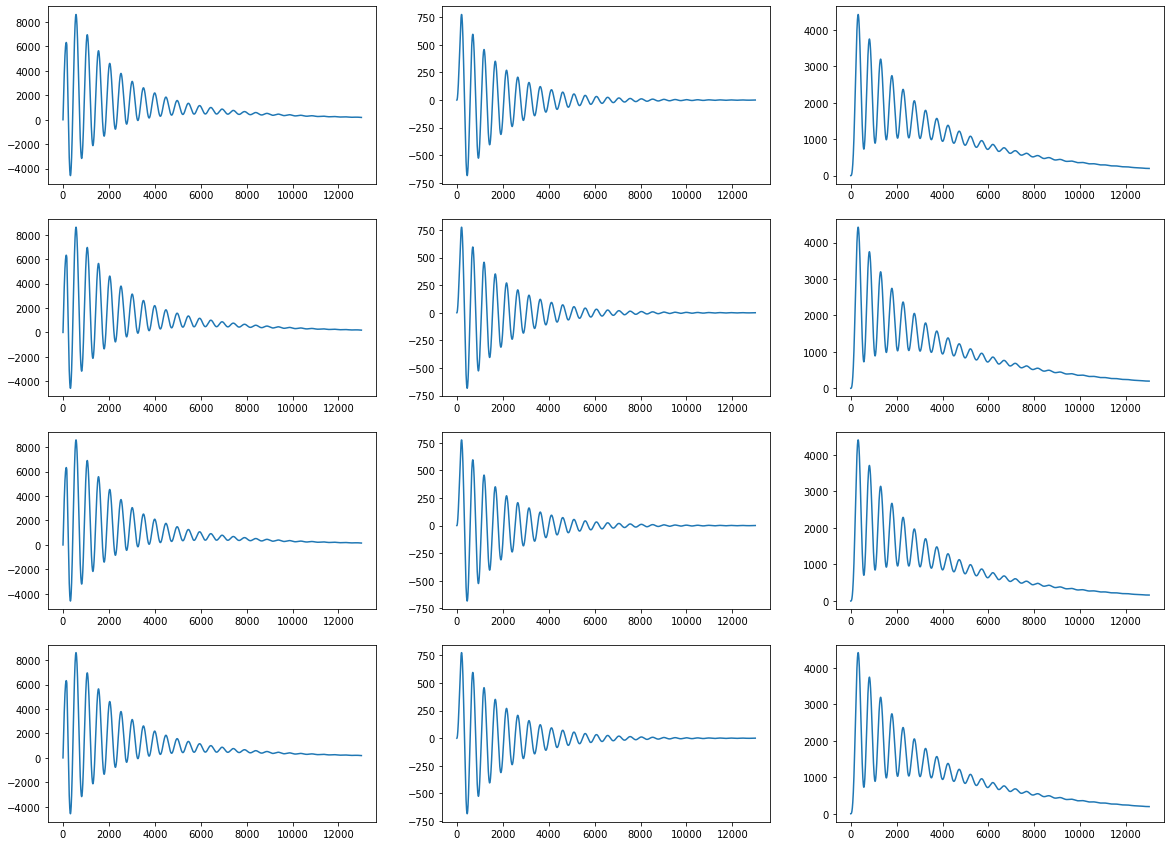

In [47]:
step = np.zeros(np.shape(voltage_impulse_list[4]))

print(np.shape(step))

step[0:167,:] = 600

tout,yout,step_response = lsim((A,B,C,D),step,half_time)

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(step_response[0:13000,i])

In [44]:
xout_step_list = []
Atilde_step_list = []
bop_step_list = []

num_samples = 15000
for i in range(12):

    [xout,Atilde,bop_obj] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 5,
        training_set = step_response.T[:,0:num_samples],
        training_voltage = step[0:num_samples,:],
        test_voltage = half_voltages[0:num_samples,:],
        time = half_time[0:num_samples],
        Btilde = B,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0)
    xout_step_list.append(xout)
    Atilde_step_list.append(Atilde)
    bop_step_list.append(bop_obj)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 4272905433710256.5. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:270: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[right_half] = 1j * eigenvalues[right_half].imag


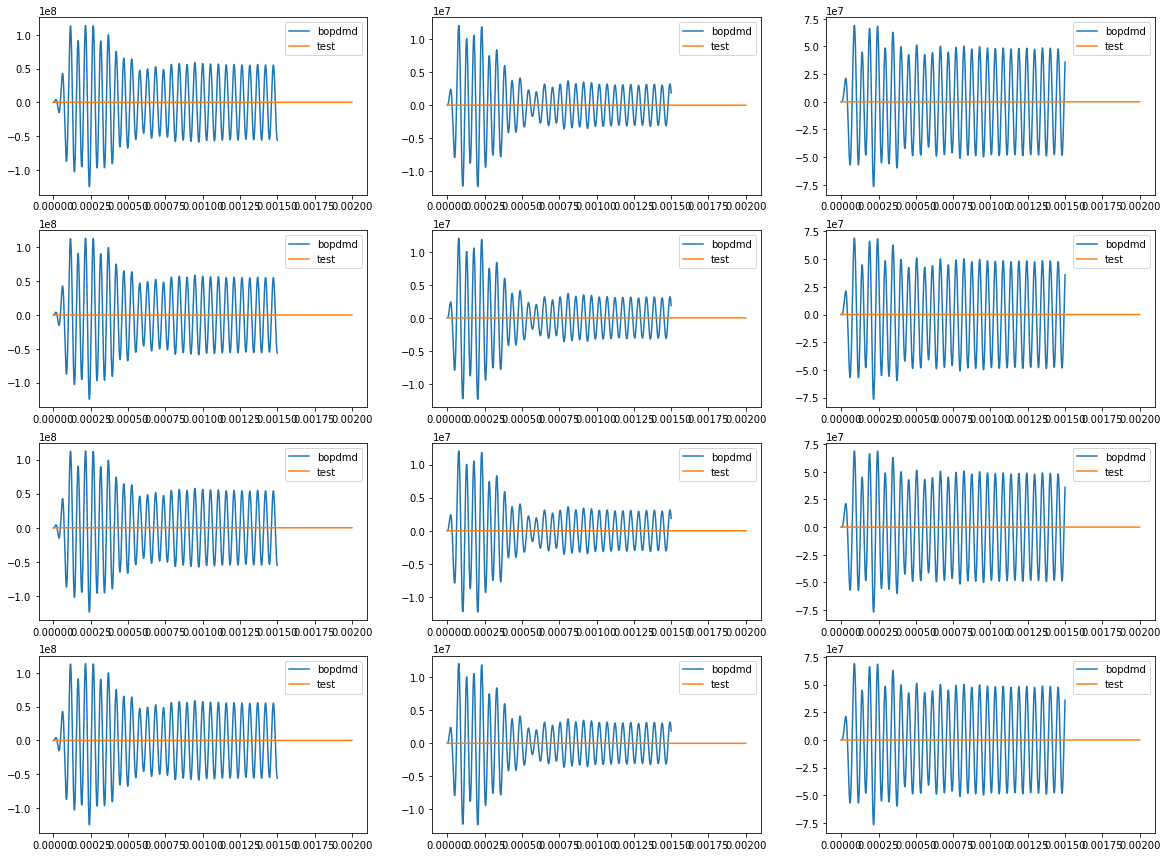

In [48]:
num = 11
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(half_time[0:num_samples],np.real(xout_step_list[num][:,i]))
    plt.plot(half_time,xout_train[:,i])
    plt.legend(['bopdmd','test'])

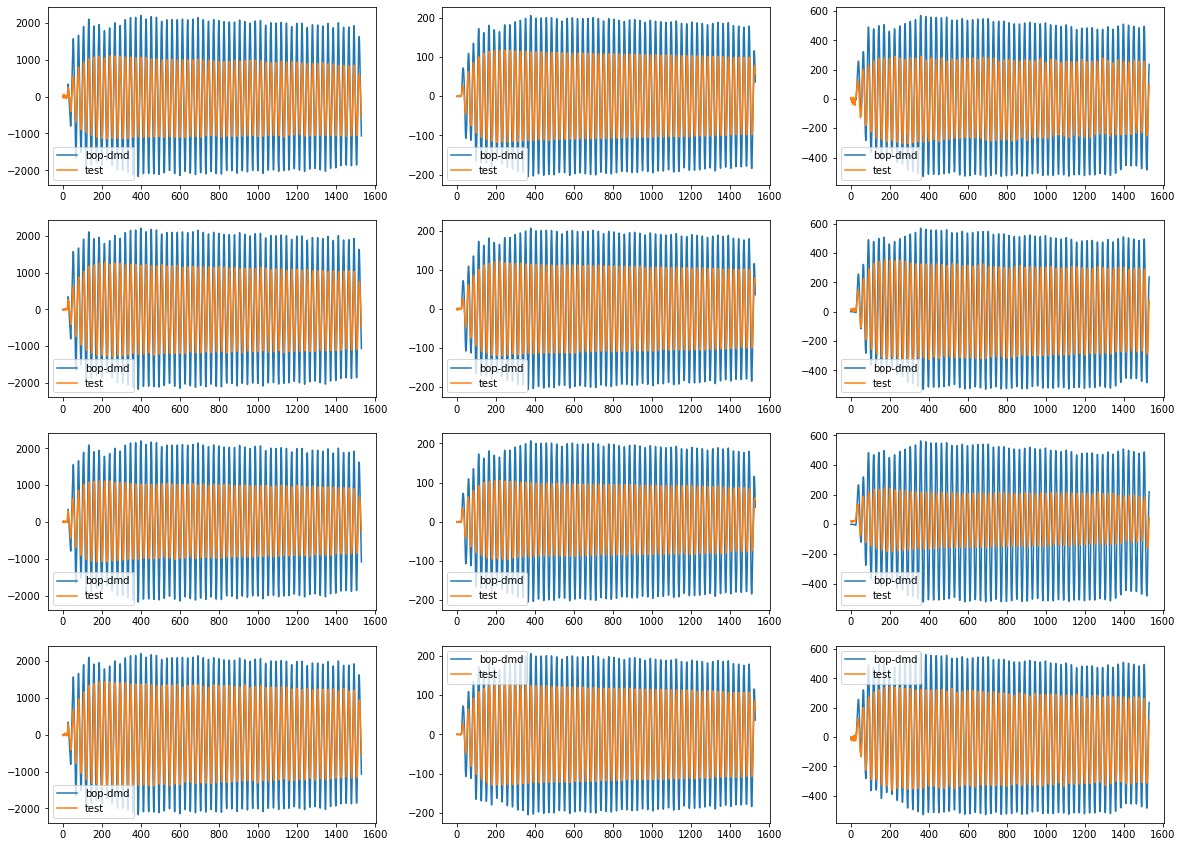

In [49]:
tout,yout,xout = lsim((Atilde_step_list[10],B,C,D),inputs_list[1],experiment_time)


plt.figure(figsize = (20,15))
num = 3
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(np.real(xout[:,i]))
    plt.plot(trajectory_list[1][:,i])

    
    plt.legend(['bop-dmd','test'])

In [50]:
np.shape(xout_train)

(20000, 12)

## There's something weird going on with the voltage waveforms. When I take my model that was trained on an impulse response, and then give it one of my simulated waveforms, we get these massive scale factor errors. But if I take an experimental waveform, and then I scale it up, we get no problems at all and it actually fits super well. 

### We're going to compare how the BOP model trained from an impulse response does at matching test data that comes from a scaled version of our experimental waveform. 



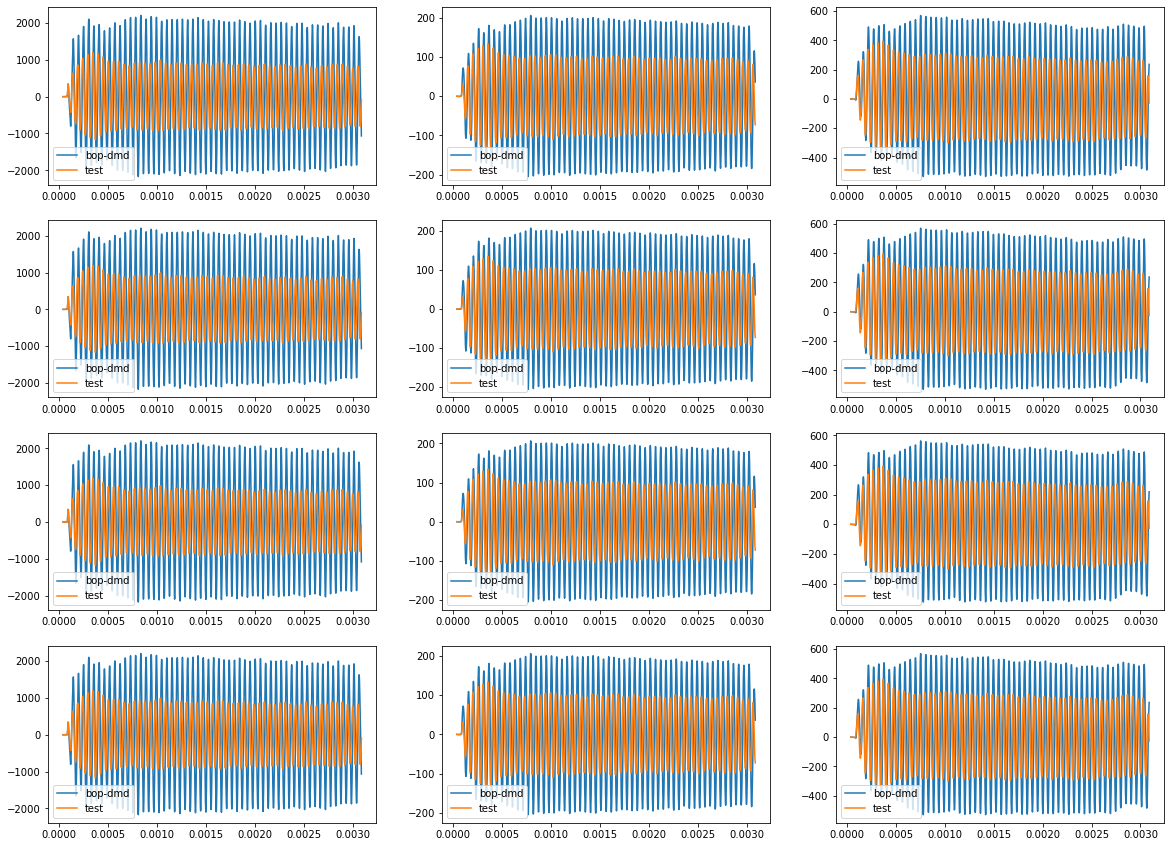

In [51]:


tout,yout,xout_test_exp = lsim((A,B,C,D), inputs_list[1],experiment_time.reshape(len(experiment_time)))

tout,yout,xout_bop = lsim((Atilde_step_list[10],B,C,D),inputs_list[1],experiment_time.reshape(len(experiment_time)))

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    
    plt.plot(experiment_time,np.real(xout_bop[:,i]))
    plt.plot(experiment_time,xout_test_exp[:,i])

    plt.legend(['bop-dmd','test'])

## I'm going to take this little snippet from an experimental waveform and use that as my impulse. Probably going to scale it up as well, but we'll try some things

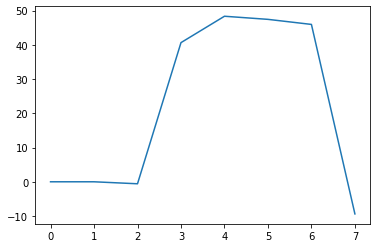

In [52]:
plt.plot(inputs_list[1][20:28,0])


impulse_experiment = np.zeros(np.shape(inputs_list[1]))

impulse_experiment[20:28,:] = inputs_list[1][20:28,:]

tout,yout,xout_experiment_impulse = lsim((A,B,C,D),impulse_experiment,experiment_time.reshape(len(experiment_time)))



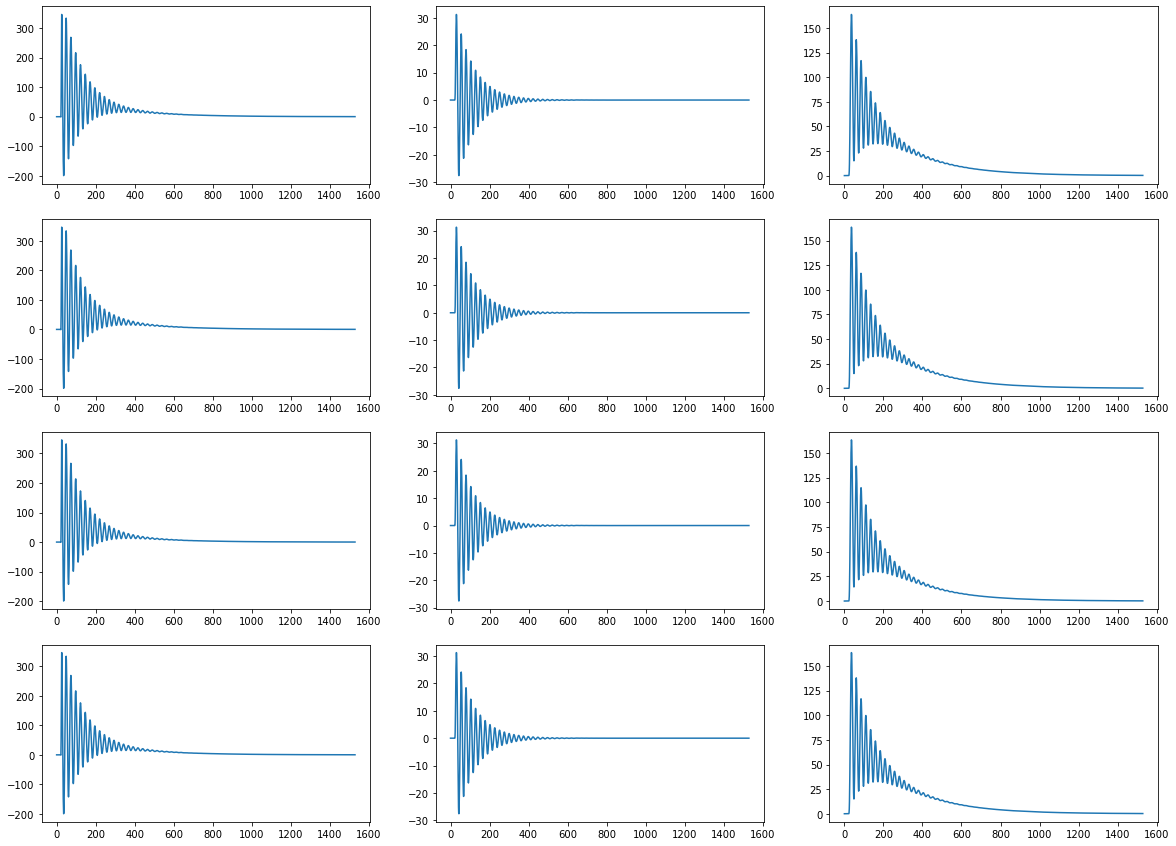

In [53]:
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.plot(xout_experiment_impulse[:,i])

In [54]:
xout_list = []
Atilde_list = []
bop_list = []


for i in range(12):

    [xout,Atilde,bop_obj] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 5,
        training_set = xout_experiment_impulse.T,
        training_voltage = impulse_experiment,
        test_voltage = inputs_list[1],
        time = experiment_time.reshape(len(experiment_time)),
        Btilde = B,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0)
    xout_list.append(xout)
    Atilde_list.append(Atilde)
    bop_list.append(bop_obj)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 5.414236750896388e+16. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:270: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[right_half] = 1j * eigenvalues[right_half].imag


## Funky shit is going on. It might be better to train on much lower amplitudes because we won't excite some more obscure modes? No idea. 

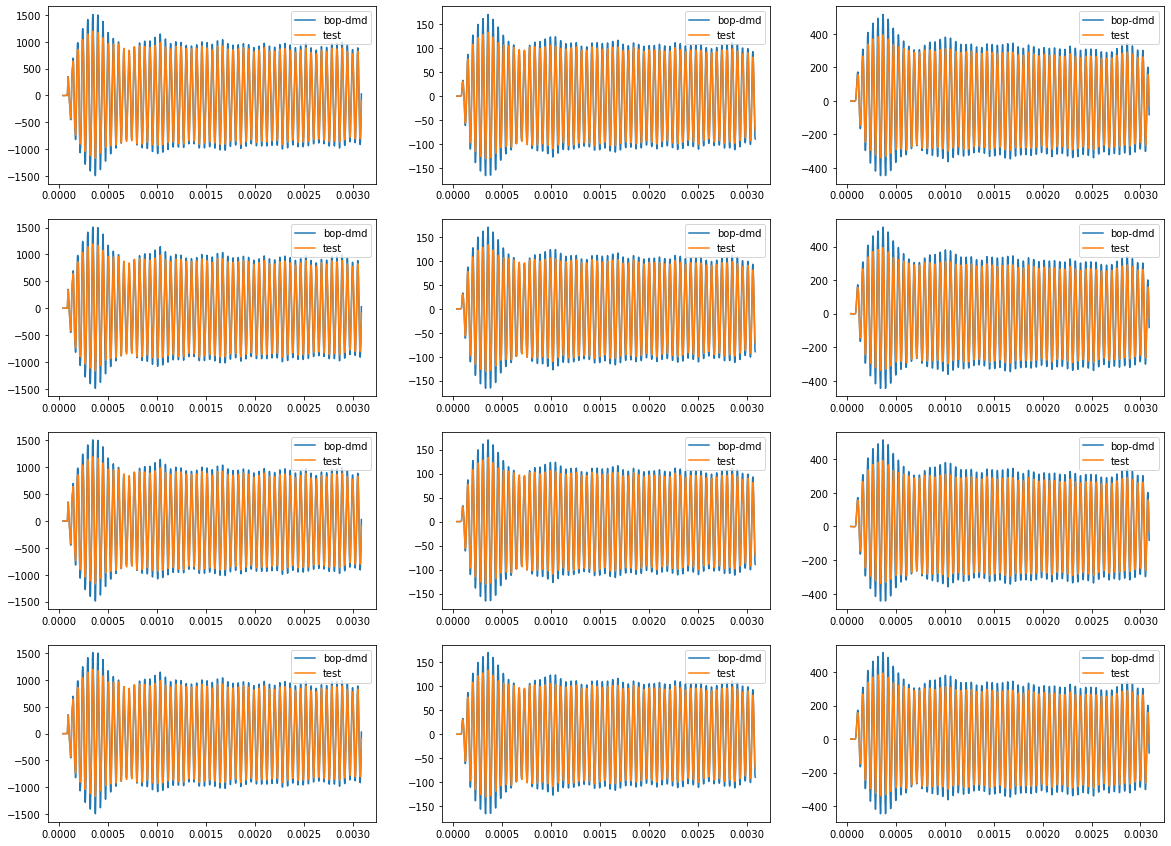

In [55]:
num  = 2
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    
    plt.plot(experiment_time,np.real(xout_list[num][:,i]))
    plt.plot(experiment_time,xout_test_exp[:,i])

    plt.legend(['bop-dmd','test'])

## So I took this little impulse from an experimental waveform, simulated my ss model with it, trained bop on that, and then below is when that BOP model is given a full experimental waveform. Not too bad

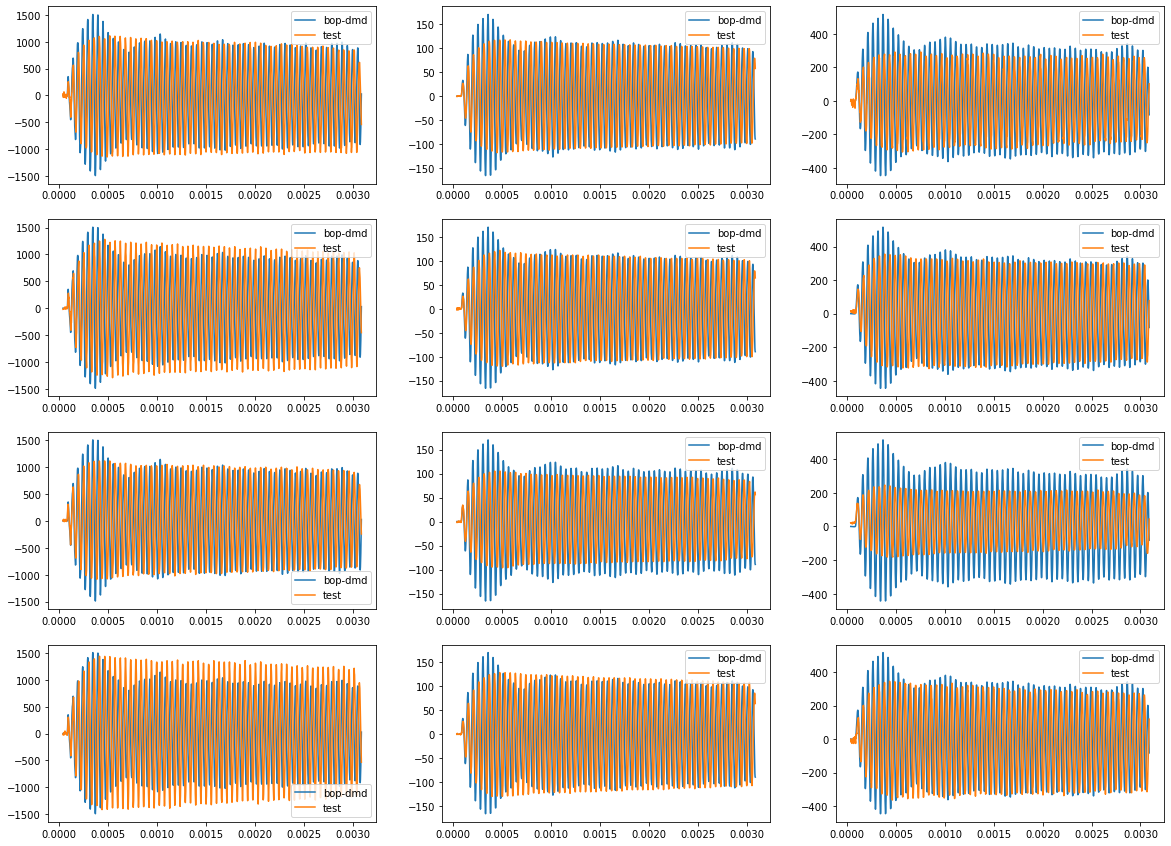

In [56]:
#How do we compare to the actual experimental vacuum shot?

tout,yout,xout = lsim((Atilde_list[2],B,C,D),inputs_list[1],experiment_time)

plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    
    plt.plot(experiment_time,np.real(xout[:,i]))
    plt.plot(experiment_time,trajectory_list[1][:,i])

    plt.legend(['bop-dmd','test'])

Text(0, 0.5, 'imag')

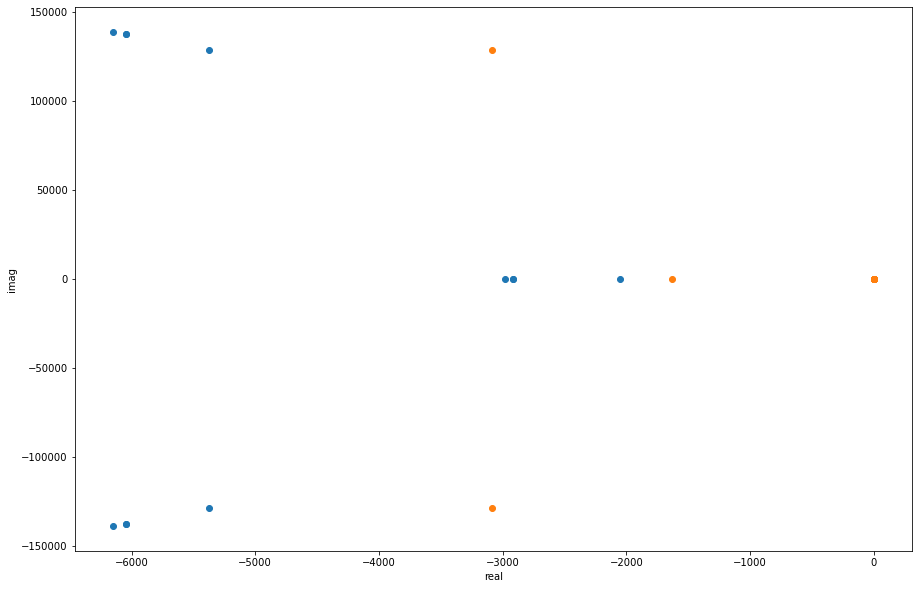

In [57]:
#Why the fuck are these models better, even if the eigenvalues still suck?
plt.figure(figsize = (15,10))
plt.scatter(np.real(np.linalg.eigvals(A)),np.imag(np.linalg.eigvals(A)))
plt.scatter(np.real(np.linalg.eigvals(Atilde_list[2])),np.imag(np.linalg.eigvals(Atilde_list[2])))

plt.xlabel('real')
plt.ylabel('imag')

## What if we change our sampling rate when we simulate our state space model? I made a simulated impulse with far fewer time samples based on the experimental data's sampling rate

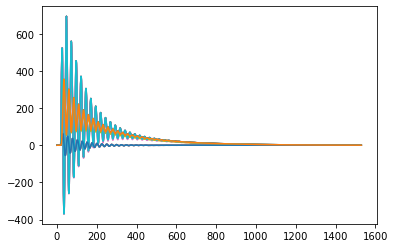

In [68]:
voltage = np.zeros(np.shape(inputs_list[0]))

voltage[20:28,:] = 50
tout,yout,xout_exp_sim = lsim((A,B,C,D),voltage,experiment_time)

plt.plot(xout_exp_sim)

In [69]:
xout_list = []
Atilde_list = []
bop_list = []


for i in range(12):

    [xout,Atilde,bop_obj] = bopdmd_train_test(
        svd_rank  = i+1,
        num_trials = 5,
        training_set = xout_exp_sim.T,
        training_voltage = voltage,
        test_voltage = inputs_list[1],
        time = experiment_time.reshape(len(experiment_time)),
        Btilde = B,
        return_training_fit = False,
        conjugate_bool = True, stable_bool = True,
        noise_level = 0)
    xout_list.append(xout)
    Atilde_list.append(Atilde)
    bop_list.append(bop_obj)

C:\Users\ducks\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 1.0451448225081788e+16. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\ducks\anaconda3\lib\site-packages\pydmd\bopdmd.py:270: ComplexWarning: Casting complex values to real discards the imaginary part
  eigenvalues[right_half] = 1j * eigenvalues[right_half].imag


In [70]:
print(len(Atilde_list))

12


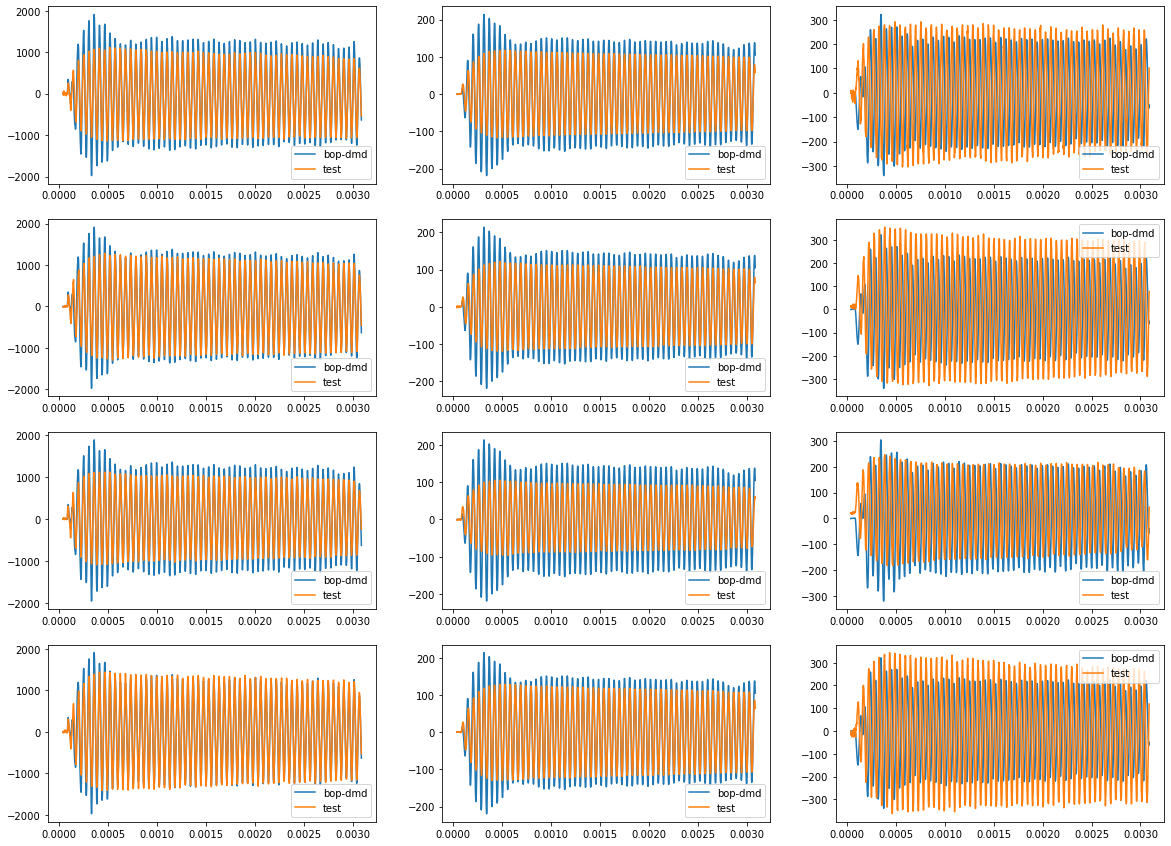

In [84]:
num  = 11
plt.figure(figsize = (20,15))
for i in range(12):
    plt.subplot(4,3,i+1)
    
    plt.plot(experiment_time,np.real(xout_list[num][:,i]))
    plt.plot(experiment_time,trajectory_list[1][:,i])

    plt.legend(['bop-dmd','test'])

Text(0, 0.5, 'imag')

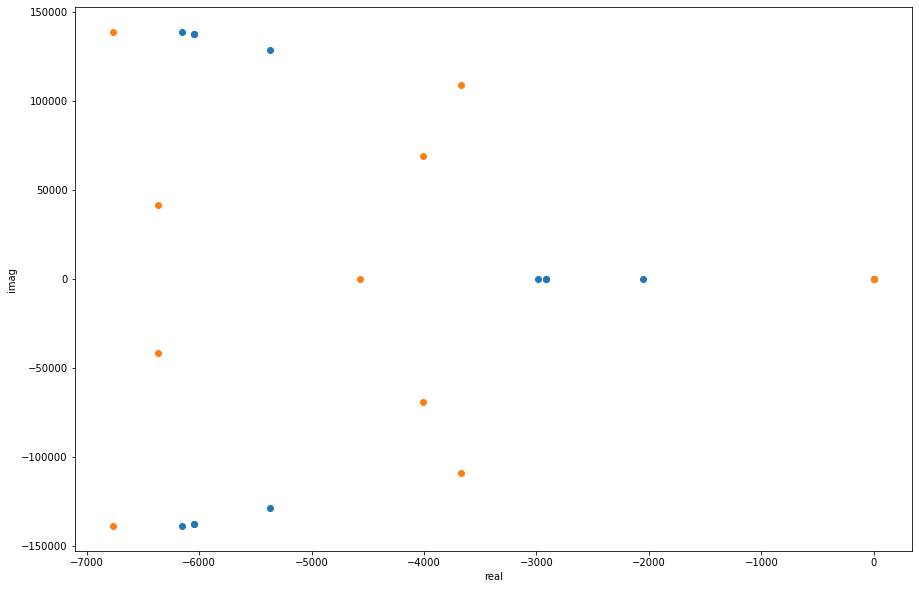

In [86]:
plt.figure(figsize = (15,10))
plt.scatter(np.real(np.linalg.eigvals(A)),np.imag(np.linalg.eigvals(A)))
plt.scatter(np.real(np.linalg.eigvals(Atilde_list[11])),np.imag(np.linalg.eigvals(Atilde_list[11])))

plt.xlabel('real')
plt.ylabel('imag')